# ECG Arrhythmia Classification using Deep Learning

## 📌 Introduction

Electrocardiography (ECG) is a vital tool in modern healthcare, widely used to monitor the electrical activity of the heart. Each heartbeat generates a characteristic waveform, and abnormalities in this pattern can indicate different types of cardiac arrhythmias. Detecting and classifying these arrhythmias manually is time-consuming and error-prone, especially with large-scale patient monitoring.

This project leverages deep learning techniques to automatically classify heartbeats from the MIT-BIH Arrhythmia Database. We use a Convolutional Neural Network (CNN) to learn spatial patterns in ECG signals and classify beats into different arrhythmia categories.

The complete pipeline includes:
- Loading and preprocessing the ECG data
- Extracting labeled beat segments
- Normalizing and reshaping the signals
- Training a CNN classifier
- Evaluating model performance using classification metrics

## 🎯 Goal
Build a deep learning model that can classify heartbeats into multiple arrhythmia categories using single-lead ECG signals.

## 🔬 Dataset
We use the **MIT-BIH Arrhythmia Database**, one of the most well-known open ECG datasets provided by PhysioNet. It contains 48 half-hour recordings from 47 subjects with detailed beat annotations.

We focus on classifying five heartbeat types as defined in the AAMI EC57 standard:
- N: Normal beats
- S: Supraventricular premature beats
- V: Premature ventricular contractions
- F: Fusion beats
- Q: Unknown beats


In [6]:
# Install necessary packages
!pip install wfdb
!pip install scikit-learn
!pip install keras
!pip install tensorflow


In [9]:
# Importing libraries
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical


## 📥 Step 1: Load ECG Records and Annotations

We will load a few selected records from the MIT-BIH Arrhythmia Database using the `wfdb` package. Each record contains:
- ECG signals (usually 2 leads, we'll use MLII)
- Beat annotations (labels and positions)

The sampling rate is 360 Hz.


In [12]:
# Download the data from PhysioNet (only once, will create a local folder)
wfdb.dl_database(
    'mitdb',                            # MIT-BIH Arrhythmia Database
    dl_dir='mitdb',                    # Target folder to save
    records=['100', '101', '102']      # List of record IDs to download
)

# List of local records we downloaded
record_ids = ['100', '101', '102']

signals = []
labels = []

for record_id in record_ids:
    record = wfdb.rdrecord(f'mitdb/{record_id}', channels=[0])  # MLII lead
    annotation = wfdb.rdann(f'mitdb/{record_id}', 'atr')

    signal = record.p_signal.flatten()
    ann_symbols = annotation.symbol
    ann_samples = annotation.sample

    # Use only beats with known labels
    for i in range(1, len(ann_samples) - 1):
        beat_type = ann_symbols[i]
        if beat_type in ['N', 'L', 'R', 'A', 'V']:  # Select common beat classes
            # 0.5s before and after the beat (approx. 180 samples at 360 Hz)
            start = ann_samples[i] - 90
            end = ann_samples[i] + 90
            if start >= 0 and end < len(signal):
                beat_segment = signal[start:end]
                signals.append(beat_segment)
                labels.append(beat_type)

print(f"Collected {len(signals)} beats.")



Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating list of all files for: 100
Generating list of all files for: 101
Generating list of all files for: 102
Finished downloading files
Collected 4235 beats.


## 🧹 Step 2: Normalize Signals and Encode Labels

To prepare for deep learning, we need to:
- Normalize each beat signal to zero mean and unit variance
- Encode class labels numerically


In [14]:
# Convert list of beat segments to 2D numpy array
X = np.array(signals)  # Shape: (num_beats, 180)
y = np.array(labels)
print(X.shape, y.shape)

# Normalize each beat (zero mean, unit variance)
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

# Encode labels to integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Reshape for Conv1D input: (samples, time_steps, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
print("Classes:", encoder.classes_)


(4235, 180) (4235,)
X shape: (3388, 180, 1)
y shape: (3388,)
Classes: ['A' 'N' 'V']


## 🧠 Step 3: Build a 1D Convolutional Neural Network (CNN)

We’ll use a simple but effective 1D CNN architecture to classify ECG beats. This model:
- Extracts time-based features using `Conv1D` layers
- Reduces dimensionality using `MaxPooling1D`
- Uses `Dropout` to prevent overfitting
- Ends with a `Dense` softmax layer for classification

This is well-suited for 1D biosignals like ECG.


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model(X_train.shape[1:], len(encoder.classes_))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 176, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 84, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       344,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,075 (1.35 MB)

 Trainable params: 355,075 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Step 4: Train the Model

We’ll now train the model for 15 epochs. During training:
- The model learns to distinguish between different arrhythmia classes
- We monitor accuracy and validation performance


In [17]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9174 - loss: 0.2281 - val_accuracy: 0.9906 - val_loss: 0.0531
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9892 - loss: 0.0646 - val_accuracy: 0.9917 - val_loss: 0.0398
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9911 - loss: 0.0441 - val_accuracy: 0.9917 - val_loss: 0.0296
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9905 - loss: 0.0448 - val_accuracy: 0.9917 - val_loss: 0.0253
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9906 - loss: 0.0347 - val_accuracy: 0.9929 - val_loss: 0.0207
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9913 - loss: 0.0299 - val_accuracy: 0.9929 - val_loss: 0.0222
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9930 - loss: 0.0254 - val_accuracy: 0.9941 - val_loss: 0.0153
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9932 - loss: 0.0256 - val_accuracy: 0.9941 - v

## 📉 Step 5: Plot Training History

Visualizing training and validation loss/accuracy helps diagnose underfitting or overfitting.


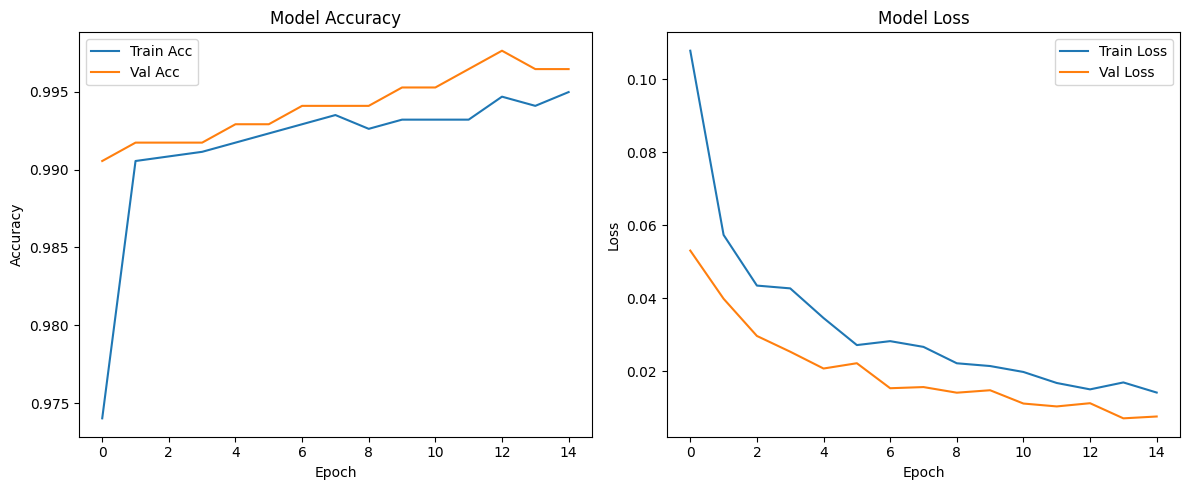

In [18]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.show()


## ✅ Step 6: Evaluate the Model on Test Data

We’ll now evaluate how well the trained model performs on unseen data:
- Accuracy: Proportion of correct predictions
- Confusion Matrix: Shows correct and incorrect predictions per class


In [19]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9965


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


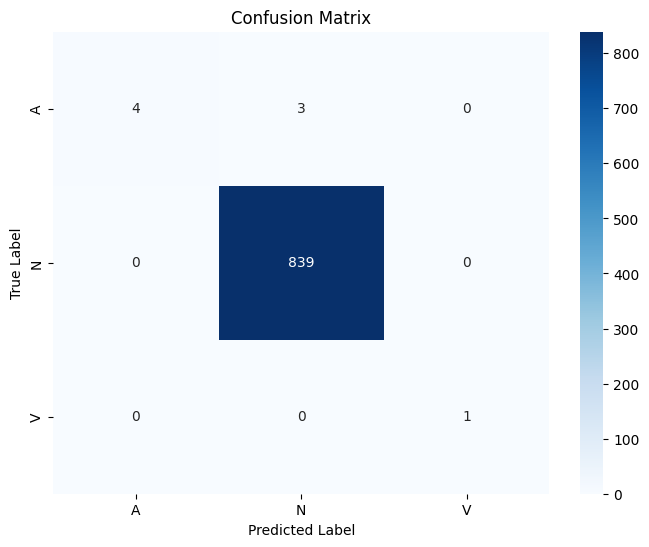

In [20]:
# Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


The confusion matrix helps you see how well the model distinguishes between classes. Diagonal values are correct predictions.

Try comparing this with raw signal plots of each class to understand why some classes may get misclassified.


In [21]:
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))


              precision    recall  f1-score   support

           A       1.00      0.57      0.73         7
           N       1.00      1.00      1.00       839
           V       1.00      1.00      1.00         1

    accuracy                           1.00       847
   macro avg       1.00      0.86      0.91       847
weighted avg       1.00      1.00      1.00       847



The classification report shows:
- **Precision**: Accuracy of positive predictions
- **Recall**: Coverage of actual class instances
- **F1-Score**: Harmonic mean of precision and recall

This gives a more complete view than accuracy alone—especially useful for imbalanced datasets like MIT-BIH.
